In [1]:
# %load_ext autoreload
# %autoreload 2
import functools
import warnings

from sklearn import metrics
import numpy as np
from classes.boosting_matrix import BoostingMatrix
from classes.dataset import Dataset
from settings import Settings
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from classes.pattern_boosting import PatternBoosting
from settings import Settings
from classes.enumeration.estimation_type import EstimationType
from data.synthetic_dataset import SyntheticDataset
import pandas as pd
import copy
from classes.analysis_patternboosting import AnalysisPatternBoosting
from data.load_dataset import load_dataset
from data import data_reader
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
import copy
from data import data_reader
from classes.wrapper_pattern_boosting import WrapperPatternBoosting
from jupiter_notebook_functions import *
import warnings
from typing import List, Tuple, Optional
from classes.analysis_wrapper_pattern_boosting import AnalysisWrapperPatternBoosting


In [7]:
# Settings

dataset_name = "5_k_selection_graphs"

# the model will be searched in the directory results/jupiter
pattern_boosting_model_name = "frequency_matrix"

max_n_learners = 5000

max_path_length = [2, 5]

max_depth = 1

errors_test_list = []
errors_train_list = []
n_learners_list = []
labels_list = []

print("Done")

Done


In [8]:
# run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
print("run classical XGB with depth 1 using different number of learners")

# Load the dataset with the matrix with all possible paths

try:
    old_n_learners_limited_path_xgb = data_reader.load_data(directory="results/jupiter/plot",
                                                            filename="old_n_learners_limited_path_xgb")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_limited_path_xgb = 0
if max_n_learners >= old_n_learners_limited_path_xgb:

    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

    dataset = load_dataset(dataset_name)

    # get the frequency matrix
    print("get the frequency matrix")
    '''
    if isinstance(pattern_boosting, PatternBoosting):
        frequency_matrix = pattern_boosting.create_boosting_matrix_for(dataset)

    elif isinstance(pattern_boosting, WrapperPatternBoosting):
        frequency_matrix = pattern_boosting.create_ordered_boosting_matrix(dataset)
    '''
    frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                    columns=pattern_boosting.boosting_matrix.get_header())

    print(len(pattern_boosting.boosting_matrix.get_header()))

    # run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
    print("run classical XGB with depth 1 using different number of learners")
    pool = ThreadPool(min(10, len(max_path_length)))

    xgb_err = pool.map(
        functools.partial(get_XGB_error_and_variable_importance,
                          frequency_matrix=copy.deepcopy(frequency_matrix),
                          labels=dataset.labels,
                          max_number_of_learners=max_n_learners),
        max_path_length)

    xgb_test_err, xgb_train_err = zip(*xgb_err)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_limited_path_xgb", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(xgb_test_err, filename="test_err_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(xgb_train_err, filename="train_err_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)

    labels_list_limited_path_xgb = []
    for i, length in enumerate(max_path_length):
        n_learners_list.append(list(range(1, len(xgb_train_err[i]) + 1)))
        labels_list_limited_path_xgb.append('XGB path ' + str(length))

    data_reader.save_data(n_learners_list, filename="number_of_learners_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)

    data_reader.save_data(labels_list_limited_path_xgb, filename="labels_list_limited_path_xgb",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)


run classical XGB with depth 1 using different number of learners


/var/folders/qc/wxh4slj57lz9vzyv3nfj5_gr0000gn/T/ipykernel_1665/2739343478.py:10: UserWarning: Old number of learners not found
  warnings.warn("Old number of learners not found")


NameError: name 'data_reader' is not defined

In [3]:
# Run xgb full power and on the frequency matrix with all possible paths
print("Run xgb full power and on the frequency matrix with all possible paths")

try:
    old_n_learners_full_xgb_full_matrix = data_reader.load_data(directory="results/jupiter/plot",
                                                                filename="old_n_learners_full_xgb_full_matrix")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_full_xgb_full_matrix = 0
if max_n_learners >= old_n_learners_full_xgb_full_matrix:
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

    dataset = load_dataset(dataset_name)

    frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                    columns=pattern_boosting.boosting_matrix.get_header())

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth
    test_err_full_power_xgb, train_err_full_power_xgb = get_XGB_error_and_variable_importance(
        max_path_length=200,
        frequency_matrix=copy.deepcopy(frequency_matrix),
        labels=dataset.labels,
        max_number_of_learners=max_n_learners,
        xgb_settings=xgb_settings)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(test_err_full_power_xgb, filename="test_err_full_power_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(train_err_full_power_xgb, filename="train_err_full_power_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(list(range(1, len(test_err_full_power_xgb) + 1)),
                          filename="number_of_learners_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data('XGB depth ' + str(max_depth) + ' on all paths', filename="labels_list_full_xgb_full_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)



Run xgb full power and on the frequency matrix with all possible paths
[0]	validation_0-rmse:0.03163	validation_1-rmse:0.03053
[1]	validation_0-rmse:0.03144	validation_1-rmse:0.03044
[2]	validation_0-rmse:0.03129	validation_1-rmse:0.03037
[3]	validation_0-rmse:0.03116	validation_1-rmse:0.03026
[4]	validation_0-rmse:0.03103	validation_1-rmse:0.03013
[5]	validation_0-rmse:0.03091	validation_1-rmse:0.03000
[6]	validation_0-rmse:0.03079	validation_1-rmse:0.02991
[7]	validation_0-rmse:0.03067	validation_1-rmse:0.02978
[8]	validation_0-rmse:0.03056	validation_1-rmse:0.02967
[9]	validation_0-rmse:0.03045	validation_1-rmse:0.02959
[10]	validation_0-rmse:0.03034	validation_1-rmse:0.02952
[11]	validation_0-rmse:0.03024	validation_1-rmse:0.02945
[12]	validation_0-rmse:0.03015	validation_1-rmse:0.02940
[13]	validation_0-rmse:0.03006	validation_1-rmse:0.02934
[14]	validation_0-rmse:0.02997	validation_1-rmse:0.02928
[15]	validation_0-rmse:0.02989	validation_1-rmse:0.02916
[16]	validation_0-rmse:0.02

In [4]:
# Run xgb full power and on the frequency matrix given by pattern boosting
print("Run xgb full power and on the frequency matrix given by pattern boosting")

try:
    old_n_learners_full_xgb_pb_matrix = data_reader.load_data(directory="results/jupiter/plot",
                                                              filename="old_n_learners_full_xgb_pb_matrix")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners_full_xgb_pb_matrix = 0

if max_n_learners >= old_n_learners_full_xgb_pb_matrix:
    # load pattern boosting model, to use the headers found by the algorithm
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_2000_steps")
    print(pattern_boosting.test_dataset)

    pd_pattern_boosting_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                              columns=pattern_boosting.boosting_matrix.get_header())

    xgb_settings = Settings.xgb_model_parameters
    xgb_settings['max_depth'] = max_depth
    test_err_full_power_xgb_on_pattern_boosting_matrix, train_err_full_power_xgb_on_pattern_boosting_matrix = get_XGB_error_and_variable_importance_t(
        max_path_length=200,
        pattern_boosting=pattern_boosting,
        max_number_of_learners=max_n_learners,
        frequency_matrix=pd_pattern_boosting_matrix,
        xgb_settings=xgb_settings)

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(test_err_full_power_xgb_on_pattern_boosting_matrix, filename="test_err_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(train_err_full_power_xgb_on_pattern_boosting_matrix, filename="train_err_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(list(range(1, len(test_err_full_power_xgb_on_pattern_boosting_matrix) + 1)),
                          filename="number_of_learners_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data('XGB on pattern boosting matrix of 2000 steps', filename="labels_list_full_xgb_pb_matrix",
                          directory="results/jupiter/plot",
                          create_unique_subfolder=False)



In [8]:
#load all errors and merge into one
if True:
    errors_test_list = []
    errors_train_list = []
    n_learners_list = []
    labels_list = []

    # classic XGB with depth 1 using different number of learners, parallelize over the max length paths

    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)

    test_err_limited_path_xgb = data_reader.load_data(directory=directory, filename="test_err_limited_path_xgb")
    train_err_limited_path_xgb = data_reader.load_data(directory=directory, filename="train_err_limited_path_xgb")
    n_learners_list_limited_path_xgb = data_reader.load_data(directory=directory,
                                                             filename="number_of_learners_limited_path_xgb")
    label_limited_path_xgb = data_reader.load_data(directory=directory, filename="labels_list_limited_path_xgb")

    errors_test_list += test_err_limited_path_xgb
    errors_train_list += train_err_limited_path_xgb
    n_learners_list += n_learners_list_limited_path_xgb
    labels_list += label_limited_path_xgb

    #-------------------------------------------

    # full xgb full matrix
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)
    test_err_full_power_xgb = data_reader.load_data(directory=directory, filename="test_err_full_power_xgb_full_matrix")
    train_err_full_power_xgb = data_reader.load_data(directory=directory,
                                                     filename="train_err_full_power_xgb_full_matrix")
    n_learners_list_full_power_xgb = data_reader.load_data(directory=directory,
                                                           filename="number_of_learners_full_xgb_full_matrix")
    label_full_power_xgb = data_reader.load_data(directory=directory, filename="labels_list_full_xgb_full_matrix")

    errors_test_list.append(test_err_full_power_xgb)
    errors_train_list.append(train_err_full_power_xgb)
    n_learners_list.append(n_learners_list_full_power_xgb)
    labels_list.append(label_full_power_xgb)

    #-------------------------------------------

    # full xgb pattern boosting matrix
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot",
                                              unique_subfolder=False)
    test_err_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                              filename="test_err_full_xgb_pb_matrix")
    train_err_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                               filename="train_err_full_xgb_pb_matrix")
    n_learners_list_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                                     filename="number_of_learners_full_xgb_pb_matrix")
    label_full_power_xgb_pb_matrix = data_reader.load_data(directory=directory,
                                                           filename="labels_list_full_xgb_pb_matrix")

    errors_test_list.append(test_err_full_power_xgb_pb_matrix)
    errors_train_list.append(train_err_full_power_xgb_pb_matrix)
    n_learners_list.append(n_learners_list_full_power_xgb_pb_matrix)
    labels_list.append(label_full_power_xgb_pb_matrix)

    # pattern boosting

    # directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/jupiter/'
    directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_5000_max_path_length_103_5_k_selection_graphs_gbtree/'

    pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")

    errors_test_list.append(pattern_boosting.test_error)
    errors_train_list.append(pattern_boosting.train_error)
    n_learners_list.append(list(range(0, len(pattern_boosting.test_error))))
    labels_list.append('pattern boosting')
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    # directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_200_max_path_length_101_5_k_selection_graphs/wrapped_boosting/'
    directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_2000_max_path_length_102_5_k_selection_graphs_gbtree/wrapped_boosting/'
    wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")

    errors_test_list.append(wrapper_pattern_boosting.test_error)
    errors_train_list.append(wrapper_pattern_boosting.train_error)

    repeat = len(wrapper_pattern_boosting.pattern_boosting_models_list)
    #repeat= 20

    #errors_test_list[-1]=np.repeat(np.array(errors_test_list[-1]), repeat)
    #errors_train_list[-1]=np.repeat(np.array(errors_train_list[-1]), repeat)

    n_learners_list.append(np.array(range(0, len(errors_train_list[-1]))) * repeat)

    labels_list.append('wrapper pattern boosting')

    # saving the errors

    data_reader.save_data(max_n_learners, filename="old_n_learners", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_test_list, filename="errors_test_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_train_list, filename="errors_train_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(n_learners_list, filename="n_learners_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(labels_list, filename="labels_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("Done")

[18:24:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[18:24:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

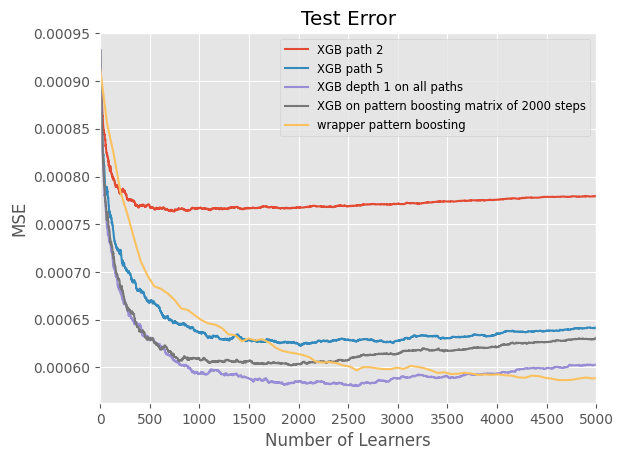

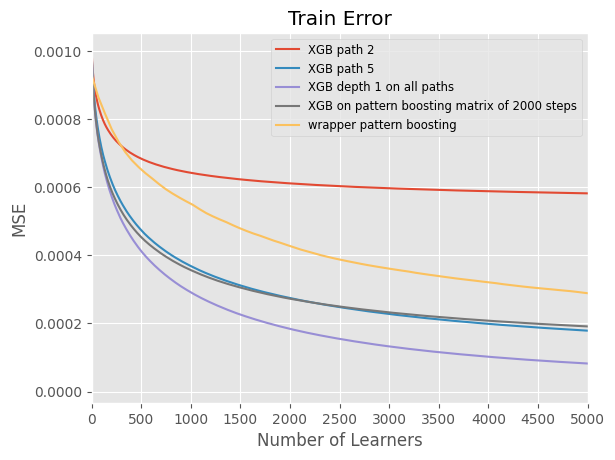

In [9]:
# load the errors
directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot", unique_subfolder=False)
errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
labels_list = data_reader.load_data(directory=directory, filename="labels_list")


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


def plot_error_evolution(error_list: List[List[float]],
                         number_of_learners_list: List[List[float]],
                         labels: List[str],
                         title: str = 'Evolution of the Error',
                         y_lim: Optional[Tuple[float, float]] = None,
                         x_lim: Optional[Tuple[float, float]] = None,
                         legend_fontsize: str = 'small') -> None:
    """
    Plots the evolution of different error series based on corresponding number of learners and error values.

    :param error_list: A list of lists, where each sublist contains the error values for a different model or condition.
    :type error_list: list[list[float]]
    :param number_of_learners_list: A list of lists of numbers representing learners that correspond to the error values.
    :type number_of_learners_list: list[list[float]]
    :param labels: A list of strings that serve as labels for the plots. Must be the same length as error_list.
    :type labels: list[str]
    :param title: The title of the plot. Defaults to 'Evolution of the Error' if not provided.
    :type title: str
    :param y_lim: An optional tuple with two float values to set the limits of the y-axis. Defaults to None if not provided.
    :type y_lim: tuple[float, float], optional
    :param x_lim: An optional tuple with two float values to set the limits of the x-axis. Defaults to None if not provided.
    :type x_lim: tuple[float, float], optional
    :param legend_fontsize: The font size of the legend text. Defaults to 'small' if not provided.
    :type legend_fontsize: str
    :return: None
    """

    if not error_list or not number_of_learners_list or not labels:
        raise ValueError("error_list, number_of_learners_list, and labels must not be empty.")

    if len(error_list) != len(labels) or len(error_list) != len(number_of_learners_list):
        raise ValueError(
            f"The number of labels ({len(labels)}) and the number of error/value series ({len(error_list)}) must match.")

    for error_values, number_of_learners_values in zip(error_list, number_of_learners_list):

        if len(error_values) != len(number_of_learners_values):
            raise ValueError("Each error sublist must be of the same length as its corresponding value sublist.")

    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    fig, ax = plt.subplots()

    for error, number_of_learners, label in zip(error_list, number_of_learners_list, labels):
        ax.plot(list(number_of_learners), list(error), label=label)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force x-axis to show only integer values

    if x_lim is not None:
        ax.set_xlim(x_lim)

    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set_xlabel('Number of Learners')
    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.legend()
    #ax.set_yscale('log')
    ax.legend(fontsize=legend_fontsize)  # Set the legend font size
    ax.grid(True)

    plt.show()


y_lim = None
x_lim = None
#y_lim = (0.00018, 0.001)
x_lim = (0, max_n_learners)

del errors_test_list[-2]
del n_learners_list[-2]
del labels_list[-2]

del errors_train_list[-2]

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [10]:
errors_test_list[-2]

[]

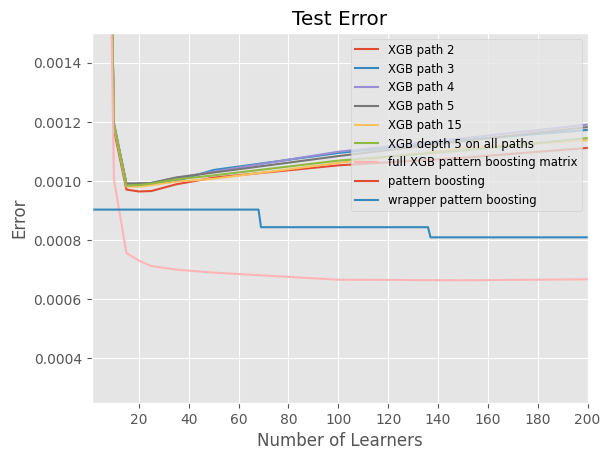

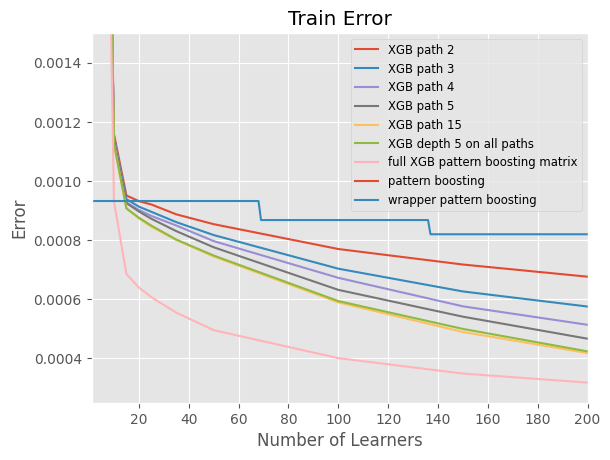

In [10]:
if True:
    # load the errors
    directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot/learning_rate_03",
                                              unique_subfolder=False)
    errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
    errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
    n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
    labels_list = data_reader.load_data(directory=directory, filename="labels_list")
# learning rate 0.3


y_lim = (0.00025, 0.0015)
x_lim = (1, 200)

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)


Run pattern boosting on for synthetic dataset for "number_of_simulations" simulations where in each simulation the noise is changed

In [4]:
folder_relative_path="results/jupiter/temp"
print("Dataset name: ", Settings.dataset_name)

if True:
    # Settings
    Settings.maximum_number_of_steps = 200

    Settings.save_analysis = True
    Settings.show_analysis = False

    Settings.dataset_name = "5k_synthetic_dataset"  # "5k_synthetic_dataset" "5_k_selection_graphs"  "60k_dataset"
    Settings.generate_new_dataset = True

    # in the error graph Print only the last N learners
    Settings.tail = 10000

    Settings.wrapper_boosting = False
    Settings.test_size = 0.2



    number_of_simulations = 200

    directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)

    try:
        final_test_error_vector = data_reader.load_data(directory=directory, filename="final_test_error_vector_variance_"+ str(Settings.noise_variance))
    except:
        final_test_error_vector = []
    try:
        final_train_error_vector = data_reader.load_data(directory=directory, filename="final_train_error_vector_variance_"+ str(Settings.noise_variance))
    except:
        final_train_error_vector = []
    try:
        missed_paths_counter = data_reader.load_data(directory=directory, filename="missed_paths_counter_"+ str(Settings.noise_variance))
    except:
        missed_paths_counter=[]



    noise_variance_list = [0.2, 0.5, 0.75, 1, 1.25, 1.5]
    noise_variance_list = [x + 0.25/2 for x in noise_variance_list] + [0.2, 0.5, 0.75, 1, 1.25, 1.5]

for noise_variance in noise_variance_list:
    print("Noise Variance")
    print(noise_variance)
    Settings.noise_variance = noise_variance

    directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)
    try:
        final_test_error_vector = data_reader.load_data(directory=directory, filename="final_test_error_vector_variance_"+ str(Settings.noise_variance))
    except:
        final_test_error_vector = []
    try:
        final_train_error_vector = data_reader.load_data(directory=directory, filename="final_train_error_vector_variance_"+ str(Settings.noise_variance))
    except:
        final_train_error_vector = []
    try:
        missed_paths_counter = data_reader.load_data(directory=directory, filename="missed_paths_counter_"+ str(Settings.noise_variance))
    except:
        missed_paths_counter=[]



    for i in range(number_of_simulations):
        print("i")
        print(i)
        dataset = load_dataset()

        train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)




        # pattern boosting
        pattern_boosting = PatternBoosting()
        pattern_boosting.training(train_dataset, test_dataset)
        final_test_error = pattern_boosting.test_error[-1]
        final_train_error = pattern_boosting.train_error[-1]
        final_test_error_vector.append(final_test_error)
        final_train_error_vector.append(final_train_error)

        selected_paths=pattern_boosting.get_selected_paths_in_boosting_matrix()
        synthetic_dataset=SyntheticDataset()
        missed_paths=[]
        for target_path in synthetic_dataset.target_paths:
            if target_path not in selected_paths:
                missed_paths.append(target_path)
        missed_paths_counter.append(len(missed_paths))


        if (i % 10) == 0:
            data_reader.save_data(final_test_error_vector, filename="final_test_error_vector_variance_" + str(Settings.noise_variance),
                      directory=folder_relative_path,
                      create_unique_subfolder=False)
            data_reader.save_data(final_train_error_vector, filename="final_train_error_vector_variance_" + str(Settings.noise_variance), directory=folder_relative_path, create_unique_subfolder=False)

            data_reader.save_data(missed_paths_counter, filename="missed_paths_counter_" + str(Settings.noise_variance),
                      directory=folder_relative_path,
                      create_unique_subfolder=False)


    data_reader.save_data(final_test_error_vector, filename="final_test_error_vector_variance_" + str(Settings.noise_variance),
                      directory=folder_relative_path,
                      create_unique_subfolder=False)

    data_reader.save_data(final_train_error_vector, filename="final_train_error_vector_variance_" + str(Settings.noise_variance),
                      directory=folder_relative_path,
                      create_unique_subfolder=False)

    data_reader.save_data(missed_paths_counter, filename="missed_paths_counter_" + str(Settings.noise_variance),
                      directory=folder_relative_path,
                      create_unique_subfolder=False)

#print("average test error")
#print(np.average(final_test_error_vector))

#print("variance test error")
#print(np.var(final_test_error_vector))

Dataset name:  5k_synthetic_dataset
/Users/popcorn/PycharmProjects/pattern_boosting/results/jupiter/temp/
Noise Variance
0.325
i
0
Creating a new labels for 5k dataset
[0]	validation_0-rmse:2.53791
[0]	validation_0-rmse:2.58271
[0]	validation_0-rmse:2.49703
[0]	validation_0-rmse:2.39527
[0]	validation_0-rmse:2.37148
[0]	validation_0-rmse:2.35903
[0]	validation_0-rmse:2.29270
[0]	validation_0-rmse:2.17828
[0]	validation_0-rmse:2.13329
[0]	validation_0-rmse:2.10927
[0]	validation_0-rmse:2.09361
[0]	validation_0-rmse:2.08163
[0]	validation_0-rmse:2.07188
[0]	validation_0-rmse:2.05984
[0]	validation_0-rmse:2.05198
[0]	validation_0-rmse:2.04469
[0]	validation_0-rmse:2.03765
[0]	validation_0-rmse:2.03006
[0]	validation_0-rmse:2.02340
[0]	validation_0-rmse:1.94120
[0]	validation_0-rmse:1.92220
[0]	validation_0-rmse:1.90406
[0]	validation_0-rmse:1.89621
[0]	validation_0-rmse:1.88881
[0]	validation_0-rmse:1.88238
[0]	validation_0-rmse:1.87586
[0]	validation_0-rmse:1.86971
[0]	validation_0-rmse:

KeyboardInterrupt: 

Analyze noise to signal

In [5]:
noise_variance_list = [0.5, 0.75, 1, 1.25, 1.5]
noise_variance_list = [x + 0.25/2 for x in noise_variance_list] + [0.2, 0.5, 0.75, 1, 1.25, 1.5]

folder_relative_path="results/jupiter/temp"
print("Dataset name: ", Settings.dataset_name)

simulation_results=[]
for variance in noise_variance_list:
    directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)
    final_test_error_vector = data_reader.load_data(directory=directory, filename="final_test_error_vector_variance_"+ str(variance))
    final_train_error_vector = data_reader.load_data(directory=directory, filename="final_train_error_vector_variance_"+ str(variance))

    missed_paths_counter = data_reader.load_data(directory=directory, filename="missed_paths_counter_"+ str(variance))
    print(variance)

    n_iter=200

    print(len(final_test_error_vector[:n_iter]))
    print("average test error")
    print(np.average(final_test_error_vector[:n_iter]))

    print("variance test error")
    print(np.var(final_test_error_vector[:n_iter]))

    print("average train error")
    print(np.average(final_train_error_vector[:n_iter]))

    print("variance train error")
    print(np.var(final_train_error_vector[:n_iter]))

    print("average missed_paths_counter")
    print(np.average(missed_paths_counter[:n_iter]))


    print("------------------------------------------------")

    simulation_results.append(final_test_error_vector[:n_iter])




Dataset name:  5k_synthetic_dataset
0.625
200
average test error
1.2497837640734344
variance test error
0.005548358921542569
average train error
0.6014402826583002
variance train error
0.0007910852976952676
average missed_paths_counter
9.025
------------------------------------------------
0.875
200
average test error
1.6513915845291764
variance test error
0.012449999179877299
average train error
0.9427740240986883
variance train error
0.0017355810109849668
average missed_paths_counter
9.345
------------------------------------------------
1.125
200
average test error
2.2336502238467744
variance test error
0.0320526117939309
average train error
1.398882565905539
variance train error
0.005161993798089815
average missed_paths_counter
10.115
------------------------------------------------
1.375
200
average test error
2.931120293697428
variance test error
0.04408241051062845
average train error
1.955898697892617
variance train error
0.008447715018522846
average missed_paths_counter
10.98


Plot Signal to noise ratio graph

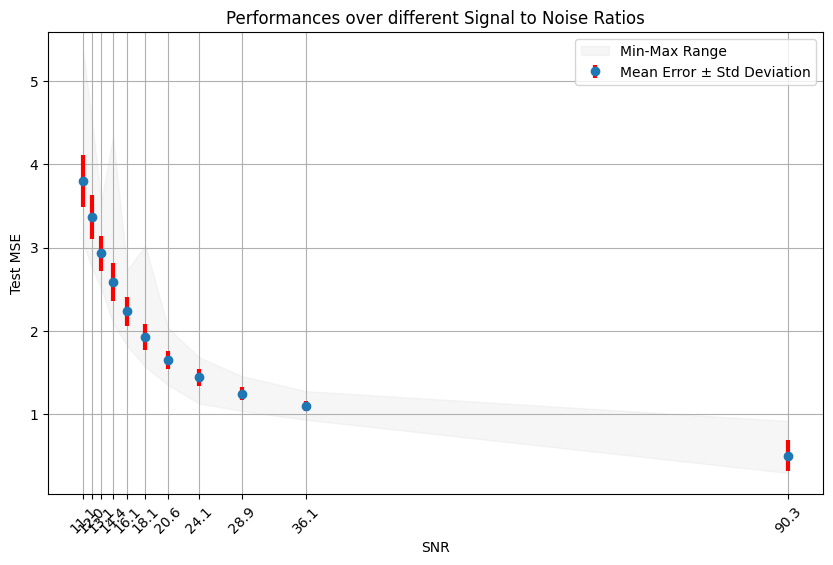

In [6]:

average_y_value=4.25


# Calculate statistics based on simulation results
mean_errors = []
variance_errors = []
min_errors = []
max_errors = []

# Assuming `simulation_results` is a list of lists (for each x, a list of 100 simulation errors)
for x_simulation_errors in simulation_results:
    mean_errors.append(np.mean(x_simulation_errors))
    variance_errors.append(np.var(x_simulation_errors))
    min_errors.append(np.min(x_simulation_errors))
    max_errors.append(np.max(x_simulation_errors))

plot_signal_to_noise_ratio(average_y_value=average_y_value, noise_variance_list=noise_variance_list,
                           variance_errors=variance_errors, mean_errors=mean_errors, min_errors=min_errors,
                           max_errors=max_errors, save_fig=True)




In [8]:
print(sorted(noise_variance_list))

[0.2, 0.5, 0.625, 0.75, 0.875, 1, 1.125, 1.25, 1.375, 1.5, 1.625]


Launch multiple times analysis (overfitting iteration) on synthetic dataset. In the file syntetic_dataset.py change the setting to get the analysis on the desired dataset


In [5]:
# Make sure the settings are right

    # Settings
Settings.maximum_number_of_steps = 100

Settings.save_analysis = True
Settings.show_analysis = False

Settings.dataset_name = "5k_synthetic_dataset"  # "5k_synthetic_dataset" "5_k_selection_graphs"  "60k_dataset"
Settings.generate_new_dataset = True

# in the error graph Print only the last N learners
Settings.tail = 10000

Settings.wrapper_boosting = False
Settings.test_size = 0.2

Settings.noise_variance=0.5

Settings.verbose = False

Settings.update_features_importance_by_comparison=True

Settings.scenario = 1
Settings.set_scenario(Settings.scenario)



In [7]:
final_test_error_vector=[]
final_train_error_vector=[]
missed_paths_counter=[]
n_selected_paths=[]
n_selected_paths_per_iterartions=[]
overfitting_iteration=[]
number_of_simulations = 200
true_positive_ratio_1=[]
selected_paths_set= set()
cumulative_paths_importance = defaultdict(float)
cumulative_times_selected = defaultdict(int)
counts = defaultdict(int)

for i in range(number_of_simulations):
        print("i")
        print(i)
        dataset = load_dataset()

        train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)




        # pattern boosting
        pattern_boosting = PatternBoosting()
        pattern_boosting.training(train_dataset, test_dataset)
        final_test_error = pattern_boosting.test_error[-1]
        final_train_error = pattern_boosting.train_error[-1]
        final_test_error_vector.append(final_test_error)
        final_train_error_vector.append(final_train_error)
        n_selected_paths_per_iterartions.append( pattern_boosting.n_selected_paths)
        true_positive_ratio_1.append(pattern_boosting.true_positive_ratio_1)
        selected_paths = pattern_boosting.get_selected_paths_in_boosting_matrix()
        n_selected_paths.append(len(selected_paths))
        # compute number of times a path is selected and average importance
        patterns_importance=pattern_boosting.get_boosting_matrix_normalized_columns_importance_values()

        for name, value in zip(pattern_boosting.get_boosting_matrix_header(), patterns_importance):
            if value > 0.0:
                cumulative_paths_importance[name] += value
                counts[name] += 1

        for name, times_selected in zip(pattern_boosting.get_boosting_matrix_header(), pattern_boosting.get_number_of_times_path_has_been_selected()):
            if times_selected > 0:
                cumulative_times_selected[name] += times_selected


        # compute overfitting iteration
        synthetic_dataset=SyntheticDataset()
        overfitting_iteration.append(early_stopping(test_errors=pattern_boosting.test_error,patience=3))
        missed_paths=[]
        for target_path in synthetic_dataset.target_paths:
            if target_path not in selected_paths:
                missed_paths.append(target_path)
        missed_paths_counter.append(len(missed_paths))
averages_importance = {name: cumulative_paths_importance[name] / number_of_simulations for name in cumulative_paths_importance}
averages_times_selected = {name: cumulative_times_selected[name] / number_of_simulations for name in cumulative_times_selected}

i
0
Creating a new labels for 5k dataset
[0]	validation_0-rmse:4.71350
[0]	validation_0-rmse:4.26920
[0]	validation_0-rmse:3.08027
[0]	validation_0-rmse:2.56568
[0]	validation_0-rmse:2.17095
[0]	validation_0-rmse:1.81735
[0]	validation_0-rmse:1.55463
[0]	validation_0-rmse:1.32628
[0]	validation_0-rmse:1.15881
[0]	validation_0-rmse:1.04906
[0]	validation_0-rmse:0.94178
[0]	validation_0-rmse:0.87493
[0]	validation_0-rmse:0.80447
[0]	validation_0-rmse:0.75570
[0]	validation_0-rmse:0.72085
[0]	validation_0-rmse:0.68005
[0]	validation_0-rmse:0.65040
[0]	validation_0-rmse:0.63064
[0]	validation_0-rmse:0.61658
[0]	validation_0-rmse:0.60277
[0]	validation_0-rmse:0.59280
[0]	validation_0-rmse:0.58322
[0]	validation_0-rmse:0.57791
[0]	validation_0-rmse:0.57227
[0]	validation_0-rmse:0.56768
[0]	validation_0-rmse:0.56381
[0]	validation_0-rmse:0.56027
[0]	validation_0-rmse:0.55670
[0]	validation_0-rmse:0.55357
[0]	validation_0-rmse:0.55061
[0]	validation_0-rmse:0.54754
[0]	validation_0-rmse:0.54458

KeyboardInterrupt: 

In [ ]:
# Print averages values of results over synthetic dataset
print("Averages importances")
print_dict_sorted_by_values(averages_importance)

print("average number of times selected")
print_dict_sorted_by_values(averages_times_selected)

print("final_test_error_vector")
print(np.average(final_test_error_vector))
print("final_train_error_vector")
print(np.average(final_train_error_vector))
print("n_selected_paths")
print(np.average(n_selected_paths))

print("n_seleted_paths_vector")
print(np.average(n_selected_paths_per_iterartions,axis=0))

print("overfitting_iteration")
print(np.average(overfitting_iteration))

print("coefficients for the syinthetic dataset")
synthetic_dataset=SyntheticDataset()
print(synthetic_dataset.target_paths)
print(synthetic_dataset.coefficients)

avg_selected_paths_per_iterartions=np.average(n_selected_paths_per_iterartions,axis=0)
synthetic_dataset=SyntheticDataset()
n_target_paths=len(synthetic_dataset.target_paths)



Plot True positive ratio

In [ ]:


# (numero totale di "target paths" trovati fino ad ora) / (numero totale di path selezionati senza contare le ripetizioni)
plot_tpr_vs_iterations(true_positive_ratios=np.average(true_positive_ratio_1,axis=0))



# (numero di path selezionati)/ (numero totale di target paths)
plot_tpr_vs_iterations(true_positive_ratios=avg_selected_paths_per_iterartions/n_target_paths)


plot_tpr_vs_iterations_different_definitions(np.average(true_positive_ratio_1,axis=0),avg_selected_paths_per_iterartions/n_target_paths)

In [ ]:
def plot_tpr_vs_iterations_max_min(true_positive_ratios_per_iteration: list[list[float]], save_fig=True):
    """
    Plots the true positive ratio with standard deviation error bars, max, and min
    against the number of iterations.
    The iterations are inferred based on the length of the true_positive_ratios list.

    :param true_positive_ratios_per_iteration: A list of list containing the TPR values at each iteration for each simulation.
    :type true_positive_ratios_per_iteration: list of list of float
    :returns: None
    """
    # Convert to numpy array for easier manipulation
    np_tpr_per_iteration = np.array(true_positive_ratios_per_iteration)

    # Calculate statistics
    mean_tpr = np.mean(np_tpr_per_iteration, axis=0)
    max_tpr = np.max(np_tpr_per_iteration, axis=0)
    min_tpr = np.min(np_tpr_per_iteration, axis=0)
    std_tpr = np.std(np_tpr_per_iteration, axis=0) # Calculate the standard deviation

    iterations = list(range(1, len(mean_tpr) + 1))

    plt.figure(figsize=(10, 6))
    plt.errorbar(iterations, mean_tpr, yerr=std_tpr, fmt='-o', color='b', label='True Positive Ratio (TPR) with Std. Dev.', ecolor='red', elinewidth=3, capsize=0)
    plt.fill_between(iterations, min_tpr, max_tpr, color='b', alpha=0.1, label='Min-Max Range')
    #plt.scatter(iterations, max_tpr, marker='^', color='g', label='Max TPR')
    #plt.scatter(iterations, min_tpr, marker='v', color='r', label='Min TPR')

    plt.xlabel('Iterations')
    plt.ylabel('True Positive Ratio')
    plt.title('True Positive Ratio vs. Iterations with Max, Min, and Std. Dev.')
    plt.legend()
    plt.grid(True)
    if save_fig is True:
        plt.savefig("true_positive_ratio_with_std_dev.pdf")
    plt.show()

plot_tpr_vs_iterations_max_min(true_positive_ratio_1,save_fig=True)

Cross Validation, in case synthetic dataset is used, change the file synthetic_dataset.py to have different target paths

In [8]:
# settings

Settings.maximum_number_of_steps = 100

Settings.save_analysis = True
Settings.show_analysis = False

Settings.dataset_name = "5k_synthetic_dataset"  # "5k_synthetic_dataset" "5_k_selection_graphs"  "60k_dataset"
Settings.generate_new_dataset = True

# in the error graph Print only the last N learners
Settings.tail = 10000

Settings.wrapper_boosting = False
Settings.test_size = 0.2

Settings.noise_variance=0.2

Settings.verbose = False

folder_relative_path="results/jupiter/cross_validation"

In [9]:

#launch this function, it will save automatically all the data
cros_validation_synthetic_dataset(folder_relative_path,n_iterations=200, k_folds=5)




KeyboardInterrupt



In [2]:
#Load data and print result
Settings.scenario = 3
Settings.set_scenario(Settings.scenario)

folder_relative_path="results/jupiter/cross_validation"
directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)

list_overfitting_iterations = data_reader.load_data(directory=directory, filename="list_overfitting_iterations_"+ str(Settings.noise_variance) + '_scenario_' + str(Settings.scenario))
list_of_test_errors = data_reader.load_data(directory=directory, filename="list_of_test_errors_"+ str(Settings.noise_variance) + '_scenario_' + str(Settings.scenario))
list_n_selected_paths = data_reader.load_data(directory=directory, filename="list_n_selected_paths_"+ str(Settings.noise_variance) + '_scenario_' + str(Settings.scenario))


print("average overfitting iteration:")
print(np.average(list_overfitting_iterations[:200]))

print("max overfitting iteration")
print(max(list_overfitting_iterations))

print("std overfitting iteration:")
print(np.std(list_overfitting_iterations[:200]))


print("average test error, std")
final_test_error_list = []
for test_error in list_of_test_errors:
    final_test_error_list.append(test_error[-1])

print(np.average(final_test_error_list[:200]), np.std(final_test_error_list[:200]))

print('n_selected paths, std ')


print(np.average(list_n_selected_paths[:200]),np.std(list_n_selected_paths[:200]))



average overfitting iteration:
280.015
max overfitting iteration
299
std overfitting iteration:
32.5920968180938
average test error, std
0.6550554308711054 0.09562989480707344
n_selected paths, std 
75.34 7.2418505922174345


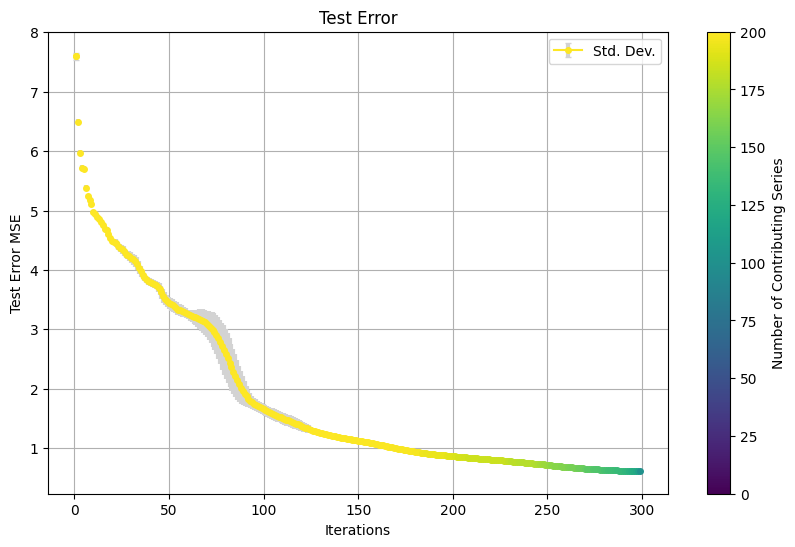

In [3]:
plot_test_error_vs_iterations(list_of_test_errors, save_fig = True)

Perform cross validation for normal dataset:

In [2]:
# settings

Settings.maximum_number_of_steps = 400

Settings.save_analysis = True
Settings.show_analysis = False

Settings.dataset_name = "5_k_selection_graphs"  # "5k_synthetic_dataset" "5_k_selection_graphs"  "60k_dataset"
Settings.generate_new_dataset = False

# in the error graph Print only the last N learners
Settings.tail = 10000

Settings.wrapper_boosting = False
Settings.test_size = 0.2

Settings.noise_variance=0.2

Settings.wrapper_boosting = True
Settings.verbose = False

In [3]:

dataset = load_dataset()

train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)

overfitting_iteration, test_error, n_selected_paths, _ = perform_cross_validation(train_dataset, test_dataset, k=5, random_seed=None, patience=3)

name_addition =  '_5_k_selection_graphs'
folder_relative_path = "results/jupiter/cross_validation"

directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)

save_data(data=[overfitting_iteration, test_error, n_selected_paths],
                  names=['list_overfitting_iterations_' + name_addition, 'list_of_test_errors_' + name_addition,
                         'list_n_selected_paths_' + name_addition], directory=directory)


[0]	validation_0-rmse:0.03164


KeyboardInterrupt: 

In [ ]:
name_addition =  '_5_k_selection_graphs'
folder_relative_path = "results/jupiter/cross_validation"




directory = data_reader.get_save_location(folder_relative_path=folder_relative_path, unique_subfolder=False)

list_overfitting_iterations = data_reader.load_data(directory=directory, filename='list_overfitting_iterations_' + name_addition)
list_of_test_errors = data_reader.load_data(directory=directory, filename='list_of_test_errors_' + name_addition)
list_n_selected_paths = data_reader.load_data(directory=directory, filename='list_n_selected_paths_' + name_addition)


print("overfitting_iterations")
print(list_overfitting_iterations)

print("test_errors iteration")
print(list_of_test_errors)

print("n_selected_paths")
print(len(list_n_selected_paths))




Load a model and analyze test error of a trained model

In [4]:
#analyze wrapper boosting

from data import data_reader


directory = ("/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_2000_max_path_length_5_60k_dataset_gbtree_0008/wrapped_boosting")

wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")
print("loaded")
test_error = wrapper_pattern_boosting.test_error
print(test_error)






loaded
[0.00094129 0.00089626 0.00086343 ... 0.00044423 0.00044435 0.00044429]


In [3]:
paths_in_header = set()
for model in wrapper_pattern_boosting.get_trained_pattern_boosting_models():
            model_paths = model.boosting_matrix.get_header()
            paths_in_header.update(model_paths)

print(len(list(paths_in_header)))

50361


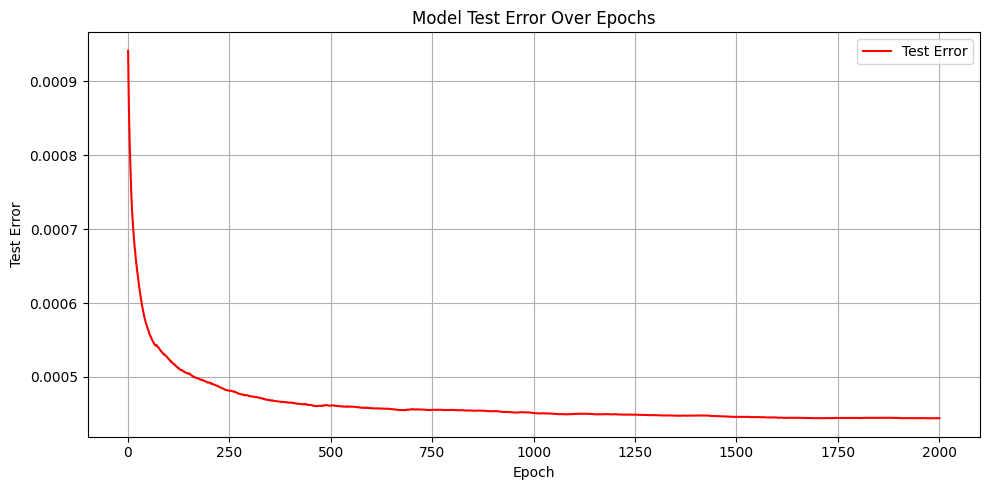

In [5]:
import matplotlib.pyplot as plt

# Create the plot

plt.figure(figsize=(10, 5))
plt.plot(range(1,len(test_error)+1), test_error, label='Test Error', color='red')

# You can customize the plot to better suit your needs
plt.title('Model Test Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [10]:

print(f"{early_stopping(test_error,patience=10)=}")
print(f"{early_stopping(test_error,patience=50)=}")
print(f"{early_stopping(test_error,patience=100)=}")
print(f"{early_stopping(test_error,patience=200)=}")
print(f"{early_stopping(test_error,patience=300)=}")

early_stopping(test_error,patience=10)=461
early_stopping(test_error,patience=50)=461
early_stopping(test_error,patience=100)=1711
early_stopping(test_error,patience=200)=1711
early_stopping(test_error,patience=300)=1984


Analyze dataset

In [10]:
# settings



Settings.dataset_name = "60k_dataset"  # "5k_synthetic_dataset" "5_k_selection_graphs"  "60k_dataset"
Settings.generate_new_dataset = False

dataset:Dataset = load_dataset()

train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)


In [11]:
dataset_dimension=len(dataset.get_graphs_list())

metal_center_counts = defaultdict(int)
for graph in dataset.get_graphs_list():
    metal_center = tuple(graph.get_metal_center_labels()[0])
    metal_center_counts[metal_center] += 1

labels = dataset.get_labels()

In [12]:
print("possible metal centers")
print(metal_center_counts)

print("dataset_dimension")
print(dataset_dimension)

print("total different labels")
print(len(metal_center_counts))

print("min, max label")
print(min(labels),max(labels))

possible metal centers
defaultdict(<class 'int'>, {(45,): 2678, (40,): 1601, (30,): 4375, (41,): 290, (79,): 2485, (27,): 2418, (42,): 2612, (77,): 2809, (72,): 289, (24,): 1498, (25,): 1099, (28,): 5241, (26,): 2976, (43,): 183, (46,): 6530, (78,): 5092, (44,): 5228, (74,): 2114, (80,): 896, (29,): 1575, (75,): 2556, (76,): 546, (47,): 810, (39,): 282, (48,): 1088, (22,): 2032, (73,): 417, (23,): 817, (21,): 146, (57,): 116})
dataset_dimension
60799
total different labels
30
min, max label
0.013129999999999989 0.31913


Plot labels barplot

/Users/popcorn/PycharmProjects/pattern_boosting/jupiter_notebook_functions.py:446: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_str, y=counts, palette=colors)
/Users/popcorn/PycharmProjects/pattern_boosting/jupiter_notebook_functions.py:446: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=labels_str, y=counts, palette=colors)


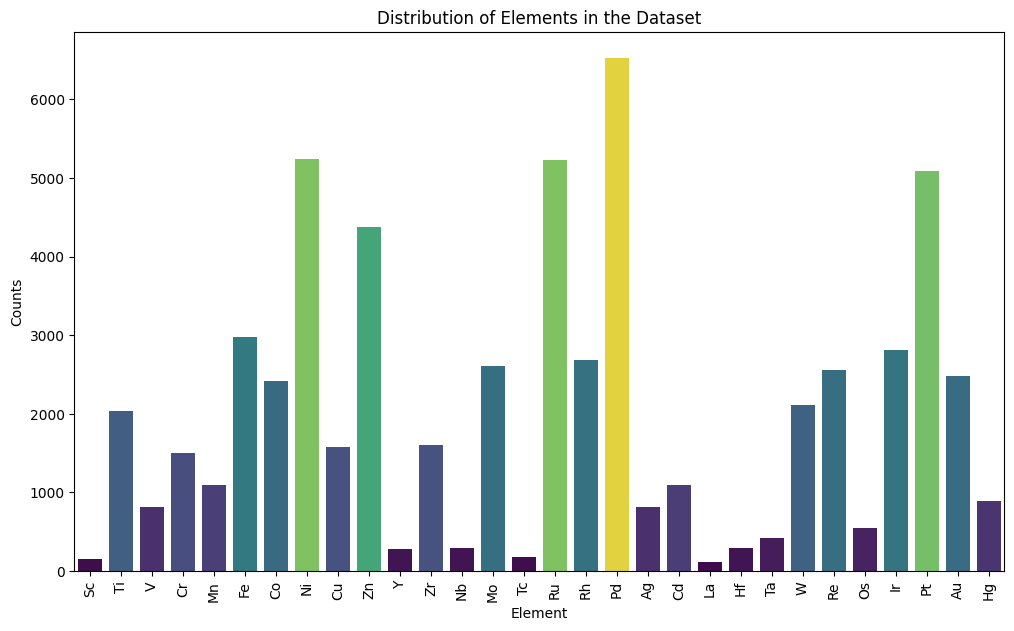

In [13]:
plot_label_distribution(metal_center_counts)

In [ ]:
#analyze wrapper boosting
directory = data_reader.get_save_location(folder_relative_path="results",
                                          unique_subfolder=True)

wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")
synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

analysis = AnalysisWrapperPatternBoosting(pattern_boosting)
analysis.plot_all_analysis(n=40, synthetic_dataset=synthetic_dataset)


In [ ]:
# plot wrapper boosting analysis on syn...
if True:
    directory = data_reader.get_save_location(folder_relative_path="results",
                                              unique_subfolder=True)

    wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")
    synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

    analysis = AnalysisWrapperPatternBoosting(wrapper_pattern_boosting)



In [37]:
# launch pattern boosting on synthetic dataset and see how many paths are found by number of iterations
if True:

    old_show_analysis = Settings.show_analysis
    old_maximum_number_of_steps = Settings.maximum_number_of_steps
    old_generate_new_dataset = Settings.generate_new_dataset
    old_wrapper_boosting = Settings.wrapper_boosting
    old_dataset_name = Settings.dataset_name

    Settings.show_analysis = True
    Settings.generate_new_dataset = True
    Settings.wrapper_boosting = True
    Settings.dataset_name = "5k_synthetic_dataset"
    Settings.considered_metal_centers = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  # first block
                                    39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  # second block
                                    57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,  # lanthanides
                                    72, 73, 74, 75, 76, 77, 78, 79, 80,  # third block
                                    89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,  # actinides
                                    104, 105, 106, 107, 108, 109, 110, 111, 112]

    dataset = load_dataset(dataset_name='5k_synthetic_dataset')

    directory = data_reader.get_save_location(folder_relative_path="results",
                                              unique_subfolder=True)

    synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

    train_dataset, test_dataset = data_reader.split_training_and_test(dataset, Settings.test_size,
                                                                      random_split_seed=Settings.random_split_test_dataset_seed)
    tested_values = range(200, 210, 50)
    boosting_matrix_header = [[]] * len(tested_values)
    selected_paths = [[]] * len(tested_values)
    total_number_of_selsected_paths = [int] * len(tested_values)
    for i, value in enumerate(tested_values):
        print(value)
        print('-----------------------------------------------------------------')
        Settings.maximum_number_of_steps = value
        settings = Settings()
        wrapper_pattern_boosting = WrapperPatternBoosting(settings=settings)
        wrapper_pattern_boosting.train(train_dataset, test_dataset)
        boosting_matrix_header[i] = wrapper_pattern_boosting.get_boosting_matrix_header()
        selected_paths[i] = wrapper_pattern_boosting.get_selected_paths()
        total_number_of_selsected_paths[i] = len(selected_paths[i])
        del wrapper_pattern_boosting

    Settings.show_analysis = old_show_analysis
    Settings.maximum_number_of_steps = old_maximum_number_of_steps
    Settings.generate_new_dataset = old_generate_new_dataset
    Settings.wrapper_boosting = old_wrapper_boosting
    Settings.dataset_name = old_dataset_name

    n_spotted_paths = [int] * len(tested_values)
    n_header_paths = [int] * len(tested_values)
    missed_paths = []

    for i, value in enumerate(tested_values):

        counter_spotted = 0
        counter_header = 0
        for path in synthetic_dataset.target_paths:
            if path in selected_paths[i]:
                counter_spotted += 1
            elif value == tested_values[-1]:
                missed_paths.append(path)
            if path in boosting_matrix_header[i]:
                counter_header += 1
        n_spotted_paths[i] = counter_spotted
        n_header_paths[i] = counter_header





Creating a new labels for 5k dataset
200
-----------------------------------------------------------------


TypeError: object of type 'NoneType' has no len()

In [3]:

def plot_found_paths(tested_values, correctly_found_paths, total_number_of_paths_explored):
    # Set up the plot
    plt.figure(figsize=(8, 6))
    plt.title("Paths Explored vs Correct Paths")
    plt.xlabel("Number of Iterations/Selected Paths")
    plt.ylabel("Number of Target Paths found")
    # Plot the two functions
    plt.plot(tested_values, correctly_found_paths, label="Correct Paths")
    #plt.plot(tested_values, total_number_of_paths_explored, label="Explored Paths")

    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()


In [4]:
tested_values = list(range(2, 70, 7)) + list(range(80, 110, 8)) + list(tested_values)
total_number_of_selsected_paths = [54, 167, 280, 392, 495, 592, 667, 737, 822, 895, 1048, 1108, 1174,
                                   1232] + total_number_of_selsected_paths
n_spotted_paths = [46, 76, 80, 85, 90, 93, 98, 101, 102, 104, 104, 104, 106, 106] + n_spotted_paths

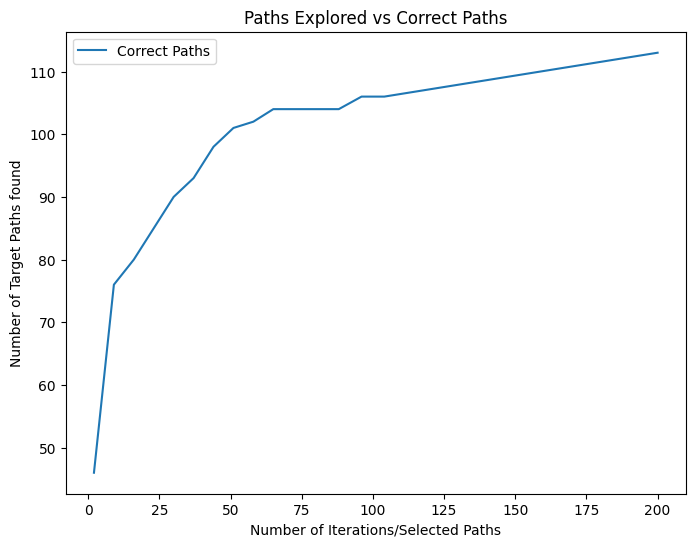

In [5]:
plot_found_paths(tested_values, n_spotted_paths, total_number_of_selsected_paths)

In [11]:
plot_found_paths(tested_values, n_header_paths, total_number_of_selsected_paths)

NameError: name 'plot_found_paths' is not defined

In [ ]:
n_header_paths

In [ ]:
n_spotted_paths

In [ ]:
total_number_of_selsected_paths


In [ ]:
# create frequency matrix of synthetic dataset
matrix = synthetic_dataset.number_paths_counting
header = synthetic_dataset.target_paths
boosting_dataframe = pd.DataFrame(matrix, columns=header)


In [ ]:
# Load the dataset with the matrix with all possible paths

directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_all_paths")

dataset = load_dataset(dataset_name)

# get the frequency matrix
print("get the frequency matrix")
frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                columns=pattern_boosting.boosting_matrix.get_header())

print(len(pattern_boosting.boosting_matrix.get_header()))

# run classical XGB with depth 1 using different number of learners, parallelize over the max length paths
print("run classical XGB with depth 1 using different number of learners")
pool = ThreadPool(min(10, len(max_path_length)))

xgb_err = pool.map(
    functools.partial(get_XGB_error_and_variable_importance,
                      frequency_matrix=copy.deepcopy(frequency_matrix),
                      labels=dataset.labels,
                      max_number_of_learners=number_of_learners),
    max_path_length)

xgb_test_err, xgb_train_err = zip(*xgb_err)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Run xgb full power and on the frequency matrix with all possible paths
print("Run xgb full power and on the frequency matrix with all possible paths")
xgb_settings = Settings.xgb_model_parameters
xgb_settings['max_depth'] = max_depth
test_err_full_power_xgb, train_err_full_power_xgb = get_XGB_error_and_variable_importance(
    max_path_length=200,
    frequency_matrix=copy.deepcopy(frequency_matrix),
    labels=dataset.labels,
    max_number_of_learners=number_of_learners,
    xgb_settings=xgb_settings)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Run xgb full power and on the frequency matrix given by pattern boosting
print("Run xgb full power and on the frequency matrix given by pattern boosting")
# load pattern boosting model, to use the headers found by the algorithm
directory = data_reader.get_save_location(folder_relative_path="results/jupiter")
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting_300_steps")
print(pattern_boosting.test_dataset)

pd_pattern_boosting_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                          columns=pattern_boosting.boosting_matrix.get_header())

test_err_full_power_xgb_on_pattern_boosting_matrix, train_err_full_power_xgb_on_pattern_boosting_matrix = get_XGB_error_and_variable_importance_t(
    max_path_length=200,
    pattern_boosting=pattern_boosting,
    max_number_of_learners=number_of_learners,
    frequency_matrix=pd_pattern_boosting_matrix,
    xgb_settings=xgb_settings)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#merging all the errors

errors_test_list += xgb_test_err
errors_train_list += xgb_train_err
for length in max_path_length:
    n_learners_list.append(number_of_learners)
    labels_list.append('XGB path ' + str(length))

errors_test_list.append(test_err_full_power_xgb)
errors_train_list.append(train_err_full_power_xgb)
n_learners_list.append(number_of_learners)
labels_list.append('XGB depth ' + str(max_depth) + ' on all paths')

errors_test_list.append(test_err_full_power_xgb_on_pattern_boosting_matrix)
errors_train_list.append(train_err_full_power_xgb_on_pattern_boosting_matrix)
n_learners_list.append(number_of_learners)
labels_list.append('XGB pattern boosting matrix')
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


errors_test_list.append(pattern_boosting.test_error)
errors_train_list.append(pattern_boosting.train_error)
n_learners_list.append(range(1, len(pattern_boosting.test_error) + 1))
labels_list.append('pattern boosting')
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_300_max_path_length_100_5_k_selection_graphs/wrapped_boosting/'

wrapper_pattern_boosting = data_reader.load_data(directory=directory, filename="wrapper_pattern_boosting")

errors_test_list.append(wrapper_pattern_boosting.test_error)
errors_train_list.append(wrapper_pattern_boosting.train_error)
n_learners_list.append(range(1, len(wrapper_pattern_boosting.test_error) + 1))
labels_list.append('wrapper pattern boosting')

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# saving the errors
try:
    old_n_learners = data_reader.load_data(directory="results/jupiter/plot", filename="old_n_learners")
except:
    warnings.warn("Old number of learners not found")
    old_n_learners = 0
if max_n_learners >= old_n_learners:
    data_reader.save_data(max_n_learners, filename="old_n_learners", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_test_list, filename="errors_test_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(errors_train_list, filename="errors_train_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(n_learners_list, filename="n_learners_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)
    data_reader.save_data(labels_list, filename="labels_list", directory="results/jupiter/plot",
                          create_unique_subfolder=False)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




In [11]:
directory = data_reader.get_save_location(folder_relative_path="results",
                                          unique_subfolder=True)
print(directory)
synthetic_dataset = data_reader.load_data(directory=directory, filename="synthetic_dataset")

/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_100_max_path_length_100_5_k_selection_graphs/wrapped_boosting/


In [12]:
import pandas as pd


def highest_corr(df, col_names):
    highest_correlations = {}
    corr_matrix = df.corr()
    for col_name in col_names:
        if col_name in corr_matrix.columns:
            corr_values = corr_matrix[col_name]
            corr_values = corr_values[corr_values.index != col_name]  # exclude self-correlation
            absolute_corr_values = corr_values.abs()  # consider absolute correlation
            highest_corr_coef = max(absolute_corr_values)
            highest_correlations[col_name] = highest_corr_coef
    return highest_correlations


In [13]:
highest_corr(boosting_dataframe, missed_paths)

{(80, 7, 7): 0.44937048253671213,
 (39, 6, 5): 1.0,
 (39, 6, 7): 1.0,
 (28, 7, 6, 6, 17): 0.36536110254418724,
 (28, 7, 16): 0.5772347644832214,
 (28, 7, 6, 15): 0.10348882385695721,
 (21, 7, 14): 0.3157148766181184,
 (28, 7, 7, 7): 0.2493995196156926,
 (28, 7, 7, 16): 0.5772347644832214,
 (57, 7, 7): 0.4421713289349044,
 (28, 7, 6, 6, 9): 0.7253731164947935,
 (28, 7, 6, 16): 0.35104192820468694,
 (28, 17): 0.28603128371792974,
 (28, 35): 0.28534888689620763,
 (28, 7, 6, 6, 6, 17): 0.25754670375141187}

In [14]:
len(missed_paths)

15

{}

Old version analysis not split

Run xgb full power and on the frequency matrix given by pattern boosting
Average value of label: 0.15584368
Dataset dimension: 1000

Setting up matrix ready
Frequency matrix ready
Learner number:  1
Learner number:  2
Learner number:  5
Learner number:  7
Learner number:  10
Learner number:  15
Learner number:  20
Learner number:  25
Learner number:  35
Learner number:  50
Learner number:  100
Learner number:  150
Learner number:  200
max path length:  200
max path length:  200
max path length:  200


In [ ]:
# load the errors
directory = data_reader.get_save_location(folder_relative_path="results/jupiter/plot", unique_subfolder=False)
errors_test_list = data_reader.load_data(directory=directory, filename="errors_test_list")
errors_train_list = data_reader.load_data(directory=directory, filename="errors_train_list")
n_learners_list = data_reader.load_data(directory=directory, filename="n_learners_list")
labels_list = data_reader.load_data(directory=directory, filename="labels_list")

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Tuple, Optional

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Tuple, Optional


def plot_error_evolution(error_list: List[List[float]],
                         number_of_learners_list: List[List[float]],
                         labels: List[str],
                         title: str = 'Evolution of the Error',
                         y_lim: Optional[Tuple[float, float]] = None,
                         x_lim: Optional[Tuple[float, float]] = None,
                         legend_fontsize: str = 'small') -> None:
    """
    Plots the evolution of different error series based on corresponding number of learners and error values.

    :param error_list: A list of lists, where each sublist contains the error values for a different model or condition.
    :type error_list: list[list[float]]
    :param number_of_learners_list: A list of lists of numbers representing learners that correspond to the error values.
    :type number_of_learners_list: list[list[float]]
    :param labels: A list of strings that serve as labels for the plots. Must be the same length as error_list.
    :type labels: list[str]
    :param title: The title of the plot. Defaults to 'Evolution of the Error' if not provided.
    :type title: str
    :param y_lim: An optional tuple with two float values to set the limits of the y-axis. Defaults to None if not provided.
    :type y_lim: tuple[float, float], optional
    :param x_lim: An optional tuple with two float values to set the limits of the x-axis. Defaults to None if not provided.
    :type x_lim: tuple[float, float], optional
    :param legend_fontsize: The font size of the legend text. Defaults to 'small' if not provided.
    :type legend_fontsize: str
    :return: None
    """

    if not error_list or not number_of_learners_list or not labels:
        raise ValueError("error_list, number_of_learners_list, and labels must not be empty.")

    if len(error_list) != len(labels) or len(error_list) != len(number_of_learners_list):
        raise ValueError(
            f"The number of labels ({len(labels)}) and the number of error/value series ({len(error_list)}) must match.")

    for error_values, number_of_learners_values in zip(error_list, number_of_learners_list):
        if len(error_values) != len(number_of_learners_values):
            raise ValueError("Each error sublist must be of the same length as its corresponding value sublist.")

    plt.style.use('ggplot')  # Set the plot style to 'ggplot'

    fig, ax = plt.subplots()

    for error, number_of_learners, label in zip(error_list, number_of_learners_list, labels):
        ax.plot(number_of_learners, error, label=label)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force x-axis to show only integer values

    if x_lim is not None:
        ax.set_xlim(x_lim)

    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.set_xlabel('Number of Learners')
    ax.set_ylabel('Error')
    ax.set_title(title)
    ax.legend()
    ax.legend(fontsize=legend_fontsize)  # Set the legend font size
    ax.grid(True)

    plt.show()


y_lim = (0.00025, 0.0015)
x_lim = (5, 300)

plot_error_evolution(errors_test_list, n_learners_list, labels_list, title="Test Error", y_lim=y_lim,
                     x_lim=x_lim)
plot_error_evolution(errors_train_list, n_learners_list, labels_list, title="Train Error", y_lim=y_lim,
                     x_lim=x_lim)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



run classical XGB with depth 1 using different number of learners
get the frequency matrix
98563
run classical XGB with depth 1 using different number of learners
Learner number:  1
Learner number: Learner number:  1
 1
Learner number:  1
Learner number:  1
Learner number:  2
Learner number:  2
Learner number:  2
Learner number:  5
Learner number:  5
Learner number:  2
Learner number:  7
Learner number:  5
Learner number:  7
Learner number:  10
Learner number:  7
Learner number:  5
Learner number:  10
Learner number:  15
Learner number:  10
Learner number:  7
Learner number:  15
Learner number:  20
Learner number:  15
Learner number:  10
Learner number:  20
Learner number:  25
Learner number:  35
Learner number:  20
Learner number:  25
Learner number:  15
Learner number:  50
Learner number:  35
Learner number:  25
Learner number:  20
Learner number:  100
Learner number:  50
Learner number:  35
Learner number:  25
Learner number:  2
Learner number:  100
Learner number:  150
Learner numb